# Inverse medium scattering problem

In the following example we use the iteratively regularized Gauss-Newton solver from `regpy.solvers.nonlinear.irgnm.IrgnmCG` for the example of __medium scattering__.

In medium scattering we try to determine a perturbation $f$ or its corresponding refractive index $1+f$ of a medium from measurements of far ﬁeld patterns $u_{\infty}$ of scattered time-harmonic acoustic waves $u_{sc}:=u - u_{inc}$ in this medium given some incident field $u_{inc}$. The total field $u$ satisfies 

$$
 \Delta u + k^2 (1+f) u = 0 \qquad \text{in } \mathbb{R}^2
$$

The __Iteratively Regularized Gauss-Newton Method (IRGNM)__ minimizes in each iteration 
$$
  f_{n+1}  = f_n + \argmin_{h} \Vert F(f_{n}) + F'[f_n] h - u_{\infty}^{obs}\Vert^{2} + \alpha_{n}  \Vert f_{n} + h - f_0\Vert^{2}
$$
where $F$ is a Fréchet-differentiable operator. The minimum is determined using an implementation of the Tikhonov regularization using a CG method that is implemented as `regpy.solvers.linear.tikhonov.TikhonovCG`.
The regularization parameter $\alpha_n$ in this structure is a decreasing geometric sequence.

## Basic imports and definition of logging level

In [ ]:
import sys
from pathlib import Path

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.colorbar as cbar

example_dir = "../../../../examples/medium_scattering"
Path(example_dir).resolve()
sys.path.insert(0, str(example_dir))


## Defining the Operator

First define the medium scattering operator for fixed measurement directions using the general medium scattering operator supplied in the `mediumscattering.py`. 

In [10]:
from mediumscattering import MediumScatteringBase
from regpy.vecsps import UniformGridFcts
from regpy import util

class MediumScatteringFixed(MediumScatteringBase):
    """Acoustic medium scattering with fixed measurement directions.

    Parameters
    ----------
    farfield_directions : array-like
        Array of measurement directions of the farfield, shape `(n, 2)` or `(n, 3)` depending on
        the problem dimension. All directions must be normalized.
    gridshape : tuple, optional
        Tuple determining the size of the grid on which the total field is
        computed. Should have 2 or 3 elements depending on the dimension of the
        problem. The domain always is taken to range from `-2*radius` to
        `2*radius` along each axis. Default values is (64,64).
    radius : float, optional
        An a-priori estimate for the radius of a circle or sphere covering the
        entire unknown object. Default value is 1.
    wave_number : float, optional
        The wave number of the incident waves. Default value is 1.
    inc_directions : array-like, optional
        Directions of the incident waves. Should be of shape `(n, 2)` or
        `(n, 3)`, depending on the dimension. Each of the `n` directions needs
        to be normalized. Default value is given by util.linspace_circle(16).
    **kwargs
        All other (keyword-only) arguments are passed to the base class, which
        see.
    """

    def __init__(self, *, 
            farfield_directions,
            gridshape=(64, 64), 
            radius=1,
            wave_number=1, 
            inc_directions = util.linspace_circle(16), 
            **kwargs):
        farfield_directions = np.asarray(farfield_directions)
        if farfield_directions.ndim != 2:
            raise ValueError(f"Farfield has to be 2 dimensional array.")
        if farfield_directions.shape[1] != len(gridshape):
            raise ValueError(f"The dimension of each farfield direction has to match the gridshap dimension.")
        if not np.allclose(np.linalg.norm(farfield_directions, axis=-1), 1):
            raise ValueError(f"The farfield directions have to be normed vectors.")
        self.farfield_directions = farfield_directions
        """The farfield directions."""

        codomain = UniformGridFcts(
            axisdata=(farfield_directions, inc_directions),
            dtype=complex
        )
        super().__init__(
            codomain,
            gridshape, 
            radius, 
            wave_number, 
            inc_directions, 
            **kwargs
        )

        self.farfield_matrix = self.normalization_factor * np.exp(
            -1j * self.wave_number * (farfield_directions @ np.asarray(self.domain.coords)[:, self.support])
        )
        """The farfield matrix."""

    def _compute_farfield(self, farfield, inc_idx, v):
        farfield[:, inc_idx] = self.farfield_matrix @ v[self.support]

    def _compute_farfield_adjoint(self, farfield, inc_idx, v):
        v[self.support] = farfield[:, inc_idx] @ self.farfield_matrix.conj()


Explicitly setting up a scattering operator using the above defined class. 

Moreover, using the defined support and domain of the scattering we can define an embedding operator as the adjoint to a coordinate projection operator.

Finally we define the full forward operator as the composition of the embedding with the scattering operator. 

In [11]:
import regpy.util as util
# building the forward  operator
radius = 1
op = MediumScatteringFixed(
    gridshape=(64, 64),
    radius=radius,
    wave_number=1,
    inc_directions=util.linspace_circle(16),
    farfield_directions=util.linspace_circle(16),
)



## Creating data

First we define a true solution as a contrast. Using this we can compute the exact data which we then perturb by some added Gaussian noise.  

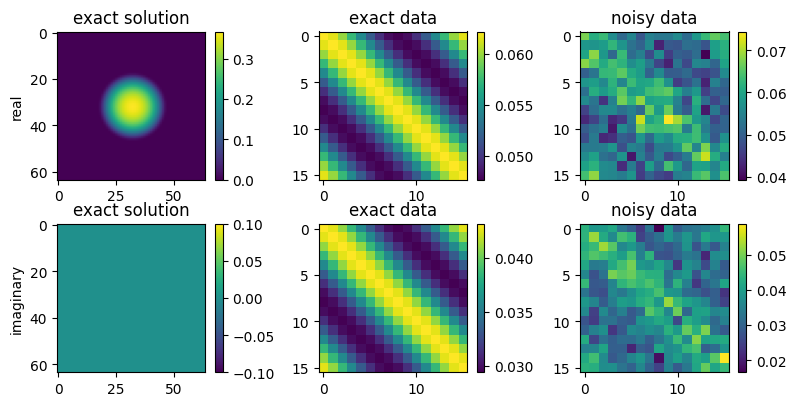

In [12]:
#creating data
exact_solution = op.domain.zeros()
r = op.domain.coord_distances()
exact_solution[r < radius] = np.exp(-1/(radius - r[r < radius]**2))

exact_data = op(exact_solution)
# create and add noise
noise = 0.005 * op.codomain.randn()
data = exact_data + noise

#plotting 
fig,axs = plt.subplots(2,3,figsize=(8,4))
fig.tight_layout()
ax = axs[0,0]
im = ax.imshow(exact_solution.real)
fig.colorbar(im,ax=ax)
ax.set_ylabel('real')
ax.set_title('exact solution')
ax = axs[0,1]
im = ax.imshow(exact_data.real)
fig.colorbar(im,ax=ax)
ax.set_title('exact data')
ax = axs[0,2]
im = ax.imshow(data.real)
fig.colorbar(im,ax=ax)
ax.set_title('noisy data')
ax = axs[1,0]
ax.set_ylabel('imaginary')
im = ax.imshow(exact_solution.imag)
fig.colorbar(im,ax=ax)
ax.set_title('exact solution')
ax = axs[1,1]
im = ax.imshow(exact_data.imag)
fig.colorbar(im,ax=ax)
ax.set_title('exact data')
ax = axs[1,2]
im = ax.imshow(data.imag)
fig.colorbar(im,ax=ax)
ax.set_title('noisy data')
plt.show();

## Define setting

In the regularization we want to have a Sobolev type smoothing penalty. Thus as a penalty we use the $H^2$ space on the domain where we can explicitly pass the support. For the data fidelity we simply use an $L^2$ setting. 

In [13]:
from regpy.hilbert import L2, Hm
from regpy.solvers import Setting

setting = Setting(
    op=op,
    # Define Sobolev norm on support via embedding
    penalty = Hm(mask=op.support,dtype=complex,index=2), 
    data_fid=L2
)


2025-12-19 15:34:07,508 INFO     Composition          :: Setting the inverse of the operator Composition(Adjoint, Pow, CoordinateProjection) to Composition(Adjoint, Pow, CoordinateProjection) overwriting the old None.
INFO:Composition:Setting the inverse of the operator Composition(Adjoint, Pow, CoordinateProjection) to Composition(Adjoint, Pow, CoordinateProjection) overwriting the old None.
2025-12-19 15:34:07,510 WARNING  Setting              :: Setting does not contain any explicit data.


## Regularization

Now using the setting and data we can setup the IRGNM solver choosing some of the parameters and defining the initial guess as the constant zero function.  

Additionally, we define a stopping rule that is composed of an maximum iteration count of 100 and a discrepancy principle with $\tau=1.1$.

In [14]:
from regpy.solvers.nonlinear.irgnm import IrgnmCG
import regpy.stoprules as rules

init = op.domain.zeros()
#set up solver
solver = IrgnmCG(
    setting, data,
    regpar=0.0001, regpar_step=0.8,
    init=init,
    cg_pars=dict(
        tol=1e-8,
        reltolx=1e-8,
        reltoly=1e-8
    )
)
#set up stopping creiteria
stoprule = (
    rules.CountIterations(100) +
    rules.Discrepancy(
        setting.h_codomain.norm, data,
        noiselevel=setting.h_codomain.norm(noise),
        tau=2.1
    )
)

## Solving

Now we can run the solver using the stopping rule:

In [15]:
reco, reco_data = solver.run(stoprule)

2025-12-19 15:34:07,532 INFO     CombineRules         :: it. 0>=100 | rel. discrep. = 9.53< 2.10
INFO:CombineRules:it. 0>=100 | rel. discrep. = 9.53< 2.10
2025-12-19 15:34:07,535 WARNING  Setting              :: Setting does not contain any explicit data.
2025-12-19 15:34:07,635 INFO     IrgnmCG.CountIterations :: it. 0>=1000
INFO:IrgnmCG.CountIterations:it. 0>=1000
2025-12-19 15:34:07,714 INFO     IrgnmCG.CountIterations :: it. 1>=1000
INFO:IrgnmCG.CountIterations:it. 1>=1000
2025-12-19 15:34:07,762 INFO     IrgnmCG.CountIterations :: it. 2>=1000
INFO:IrgnmCG.CountIterations:it. 2>=1000
2025-12-19 15:34:07,842 INFO     IrgnmCG.CountIterations :: it. 3>=1000
INFO:IrgnmCG.CountIterations:it. 3>=1000
2025-12-19 15:34:07,922 INFO     IrgnmCG.CountIterations :: it. 4>=1000
INFO:IrgnmCG.CountIterations:it. 4>=1000
2025-12-19 15:34:07,986 INFO     IrgnmCG.CountIterations :: it. 5>=1000
INFO:IrgnmCG.CountIterations:it. 5>=1000
2025-12-19 15:34:08,137 INFO     IrgnmCG.CountIterations :: it. 6>

## Plotting the results

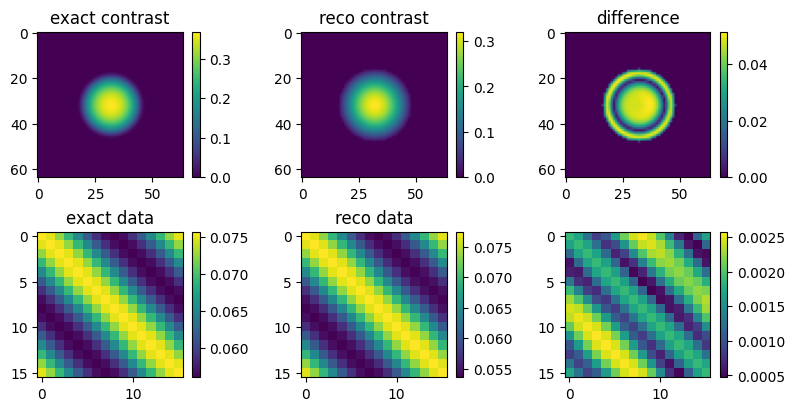

In [16]:
fig, axes = plt.subplots(ncols=3, nrows=2, constrained_layout=True,figsize=(8,4))
bars = np.vectorize(lambda ax: cbar.make_axes(ax)[0], otypes=[object])(axes)

axes[0, 0].set_title('exact contrast')
axes[1, 0].set_title('exact data')
axes[0, 1].set_title('reco contrast')
axes[1, 1].set_title('reco data')
axes[0, 2].set_title('difference')

def show(i, j, x):
    im = axes[i, j].imshow(x)
    bars[i, j].clear()
    fig.colorbar(im, cax=bars[i, j])

show(0, 0, np.abs(exact_solution))
show(1, 0, np.abs(exact_data))
show(0, 1, np.abs(reco))
show(1, 1, np.abs(reco_data))
show(0, 2, np.abs(reco - exact_solution))
show(1, 2, np.abs(exact_data - reco_data))
plt.show();
